### 1. How would you describe TensorFlow in a short sentence? What are its main features? Can you name other popular Deep Learning libraries?
**Answer:** TensorFlow is an open-source library developed by Google for numerical computation and machine learning that facilitates building and training neural networks with tools for fast computation and flexibility. Its main features include automatic differentiation, distributed training, and optimization tools. Other popular deep learning libraries include PyTorch, Keras, and MXNet.

### 2. Is TensorFlow a drop-in replacement for NumPy? What are the main differences between the two?
**Answer:** TensorFlow is not a drop-in replacement for NumPy. While both libraries are used for numerical and matrix operations, TensorFlow extends these capabilities to support deep learning and machine learning models, including GPU acceleration and automatic differentiation, which NumPy does not.

### 3. Do you get the same result with `tf.range(10)` and `tf.constant(np.arange(10))`?
**Answer:** Yes, both `tf.range(10)` and `tf.constant(np.arange(10))` will produce the same result—a TensorFlow tensor with the values 0 through 9. However, `tf.range` is native to TensorFlow and might be more efficient.

### 4. Can you name six other data structures available in TensorFlow, beyond regular tensors?
**Answer:** Yes, other data structures in TensorFlow include:
   - **Variable:** Mutable tensor values that are used to store model parameters.
   - **RaggedTensor:** Tensors with variable numbers of elements along certain axes.
   - **SparseTensor:** Efficiently stores tensors that are mostly zero.
   - **TensorArray:** List of tensors.
   - **DataSet:** Provides methods to load and manipulate data efficiently.
   - **Queue:** A data structure to store tensors across multiple steps in computation.

### 5. A custom loss function can be defined by writing a function or by subclassing the `keras.losses.Loss` class. When would you use each option?
**Answer:** You would define a custom loss function using a simple function when the loss calculation is straightforward and does not require tracking internal state. Subclassing `keras.losses.Loss` is useful when your loss function requires internal state that might need to be updated during the training process, such as weights or other parameters.

### 6. Similarly, a custom metric can be defined in a function or a subclass of `keras.metrics.Metric`. When would you use each option?
**Answer:** A function is used for simple stateless calculations, whereas subclassing `keras.metrics.Metric` is suitable for metrics that need to maintain state across batches, such as total errors or averages that update through each step of training.

### 7. When should you create a custom layer versus a custom model?
**Answer:** Create a custom layer when you need a reusable computation block that does not fit into the standard layers but can be encapsulated as a part of different models. A custom model is more comprehensive and useful when you have unique architectures or behaviors that span multiple layers and require specific ways to handle data and training.

### 8. What are some use cases that require writing your own custom training loop?
**Answer:** Use cases include when you need fine control over the training process, implementing complex behaviors like GANs (Generative Adversarial Networks) training, or when integrating non-standard computation that isn't supported by the built-in `fit` method.

### 9. Can custom Keras components contain arbitrary Python code, or must they be convertible to TF Functions?
**Answer:** Custom Keras components should generally be convertible to TF Functions to utilize graph execution, which improves performance. However, arbitrary Python code can be included, typically inside a `tf.py_function`, but this may reduce performance and lose the benefits of graph optimizations.

### 10. What are the main rules to respect if you want a function to be convertible to a TF Function?
**Answer:** To ensure convertibility:
   - Use TensorFlow operations and types.
   - Avoid Python side effects like modifying Python lists or dictionaries.
   - Ensure the function is stateless unless using `tf.Variable`.

### 11. When would you need to create a dynamic Keras model? How do you do that? Why not make all your models dynamic?
**Answer:** A dynamic Keras model, typically done by setting `dynamic=True` in a Keras model, is necessary when the model needs to execute Python logic for each batch, such as for varying sequence lengths or conditional branching. Not all models are made dynamic because dynamic models run in eager execution mode, which can be slower than the compiled graph execution mode.


In [1]:
%cd "/content/drive/Othercomputers/My laptop/Documents/Hands-On Machine Learning with Scikit-Learn and TensorFlow"

/content/drive/Othercomputers/My laptop/Documents/Hands-On Machine Learning with Scikit-Learn and TensorFlow


In [3]:
from utils import set_seed, get_chapter_directory

In [4]:
set_seed()

In [5]:
chapter_dir = get_chapter_directory(12)

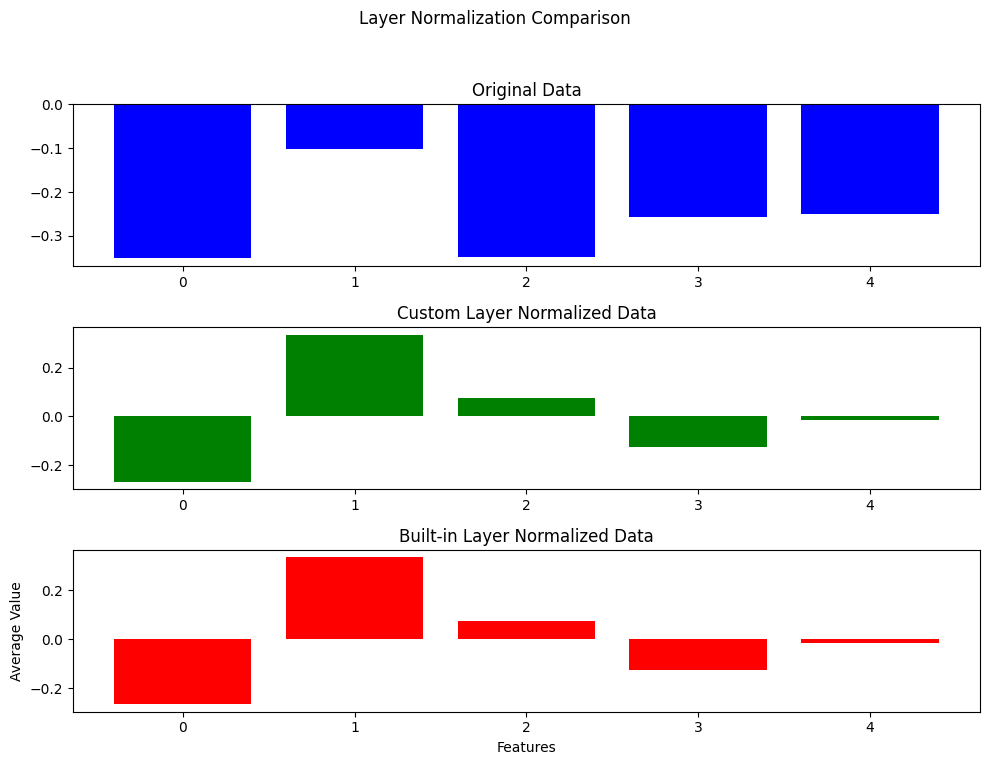

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

class CustomLayerNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=0.001, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.alpha = self.add_weight(name='alpha',
                                     shape=input_shape[-1:],
                                     initializer=tf.initializers.Ones(),
                                     trainable=True)
        self.beta = self.add_weight(name='beta',
                                    shape=input_shape[-1:],
                                    initializer=tf.initializers.Zeros(),
                                    trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        # Compute the mean and variance
        mu, variance = tf.nn.moments(inputs, axes=-1, keepdims=True)
        sigma = tf.sqrt(variance + self.epsilon)

        # Normalize the inputs
        normalized = (inputs - mu) / sigma

        # Scale and shift
        return self.alpha * normalized + self.beta

    def get_config(self):
        config = super().get_config()
        config.update({
            'epsilon': self.epsilon
        })
        return config

# Generate random data
inputs = tf.random.normal([10, 5])

# Create a custom layer normalization layer and a built-in layer
custom_layer = CustomLayerNormalization()
builtin_layer = tf.keras.layers.LayerNormalization(axis=-1, epsilon=0.001)

# Normalize the data using both layers
custom_normalized = custom_layer(inputs)
builtin_normalized = builtin_layer(inputs)

# Plotting function
def plot_data(original, normalized, normalized_builtin, title):
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))
    axes[0].bar(range(original.shape[-1]), np.mean(original, axis=0), color='b', label='Original')
    axes[0].set_title('Original Data')
    axes[1].bar(range(normalized.shape[-1]), np.mean(normalized, axis=0), color='g', label='Custom Normalized')
    axes[1].set_title('Custom Layer Normalized Data')
    axes[2].bar(range(normalized_builtin.shape[-1]), np.mean(normalized_builtin, axis=0), color='r', label='Built-in Normalized')
    axes[2].set_title('Built-in Layer Normalized Data')
    plt.xlabel('Features')
    plt.ylabel('Average Value')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot the data
plot_data(inputs, custom_normalized, builtin_normalized, 'Layer Normalization Comparison')


In [7]:
import tensorflow as tf
import numpy as np

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape images for the network
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# Convert labels to one-hot encoded vectors
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

4422102/4422102 [==============================] - 1s 0us/step


In [13]:
# Define a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Separate optimizers for different layers
optimizer_upper = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer_lower = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Loss function
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Metrics to track progress
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
validation_loss = tf.keras.metrics.Mean(name='val_loss')
validation_accuracy = tf.keras.metrics.CategoricalAccuracy(name='val_accuracy')

# Custom training step
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    # Apply different optimizers to different layers
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer_upper.apply_gradients(zip(gradients[-2:], model.trainable_variables[-2:])) # Last two layers
    optimizer_lower.apply_gradients(zip(gradients[:-2], model.trainable_variables[:-2])) # Remaining layers
    train_loss(loss)
    train_accuracy(labels, predictions)

# Custom validation step
def test_step(images, labels):
    predictions = model(images, training=False)
    v_loss = loss_fn(labels, predictions)
    validation_loss(v_loss)
    validation_accuracy(labels, predictions)

# Training loop
def train_model(epochs, train_data, test_data):
    for epoch in range(epochs):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        validation_loss.reset_states()
        validation_accuracy.reset_states()

        for images, labels in train_data:
            train_step(images, labels)

        for test_images, test_labels in test_data:
            test_step(test_images, test_labels)

        print(f'Epoch {epoch + 1}, '
              f'Loss: {train_loss.result()}, '
              f'Accuracy: {train_accuracy.result() * 100}, '
              f'Validation Loss: {validation_loss.result()}, '
              f'Validation Accuracy: {validation_accuracy.result() * 100}')

In [9]:
# Prepare the data in batches
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(10000).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

# Start training
train_model(10, train_dataset, test_dataset)

Epoch 1, Loss: 0.51263028383255, Accuracy: 82.3499984741211, Validation Loss: 0.39621421694755554, Validation Accuracy: 85.80999755859375
Epoch 2, Loss: 0.34361305832862854, Accuracy: 87.83666229248047, Validation Loss: 0.33649617433547974, Validation Accuracy: 88.08000183105469
Epoch 3, Loss: 0.3025783896446228, Accuracy: 89.29666900634766, Validation Loss: 0.32012128829956055, Validation Accuracy: 88.36000061035156
Epoch 4, Loss: 0.2747555375099182, Accuracy: 90.29166412353516, Validation Loss: 0.30645298957824707, Validation Accuracy: 88.63999938964844
Epoch 5, Loss: 0.25191041827201843, Accuracy: 90.95500183105469, Validation Loss: 0.290381520986557, Validation Accuracy: 89.22000122070312
Epoch 6, Loss: 0.23381808400154114, Accuracy: 91.67832946777344, Validation Loss: 0.28061386942863464, Validation Accuracy: 89.9000015258789
Epoch 7, Loss: 0.21593014895915985, Accuracy: 92.27667236328125, Validation Loss: 0.2658115327358246, Validation Accuracy: 90.41000366210938
Epoch 8, Loss: 0

Training loop w/ dinamically updated bar

In [14]:
from tqdm import tqdm

# Training loop
def train_model(epochs, train_data, test_data):
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        with tqdm(total=len(train_data), unit="batch") as pbar:
            for images, labels in train_data:
                train_step(images, labels)
                pbar.set_description(f"loss: {train_loss.result():.4f} - accuracy: {train_accuracy.result() * 100:.4f}")
                pbar.update(1)

        for test_images, test_labels in test_data:
            test_step(test_images, test_labels)

        print(f'Validation Loss: {validation_loss.result():.4f}, Validation Accuracy: {validation_accuracy.result() * 100:.4f}')


In [15]:
# Prepare the data in batches
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(10000).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

# Start training
train_model(5, train_dataset, test_dataset)


Epoch 1/5


loss: 0.5283 - accuracy: 81.8633: 100%|██████████| 1875/1875 [02:08<00:00, 14.59batch/s]


Validation Loss: 0.4330, Validation Accuracy: 84.3700

Epoch 2/5


loss: 0.4427 - accuracy: 84.6567: 100%|██████████| 1875/1875 [02:08<00:00, 14.55batch/s]


Validation Loss: 0.3922, Validation Accuracy: 86.0400

Epoch 3/5


loss: 0.4002 - accuracy: 86.0689: 100%|██████████| 1875/1875 [02:13<00:00, 14.04batch/s]


Validation Loss: 0.3693, Validation Accuracy: 86.8733

Epoch 4/5


loss: 0.3710 - accuracy: 87.0275: 100%|██████████| 1875/1875 [02:09<00:00, 14.46batch/s]


Validation Loss: 0.3565, Validation Accuracy: 87.2400

Epoch 5/5


loss: 0.3493 - accuracy: 87.7310: 100%|██████████| 1875/1875 [02:21<00:00, 13.21batch/s]


Validation Loss: 0.3419, Validation Accuracy: 87.7440
